# WeRateDogs - data wranging and analysis

## Table of Contents
<ul>
<li><a href="#gather">1. Gather</a></li>
<li><a href="#assess">2. Assess</a></li>
<li><a href="#quality">2.1 Quality issues</a></li>   
<li><a href="#tidiness">2.2 Tidiness issues</a></li>   
<li><a href="#clean">3. Clean</a></li>
<li><a href="#analyse">4. Analyse</a></li>
</ul>

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns - seaborn isn't installed correctly on my PC, so I commented this cell
%matplotlib inline

import tweepy
import requests
import json
import time
import math
import re

from timeit import default_timer as timer

<a id='gather'></a>
## 1 Gather necessary data

### 1.1 Read 'twitter-archive-enhanced.csv' file that downloaded manually in the folder with this project 

In [2]:
archive_df=pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### 1.2 Download tsv file from https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv and read it

In [3]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
with open('image_predictions.tsv',mode='wb') as file:
    file.write(response.content)

In [4]:
images_df = pd.read_csv('image_predictions.tsv', sep='\t')
images_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1.3 Gather Twitter data. 

Note that tweet data is stored in JSON format by Twitter. Get tweet JSON data via tweet ID using Tweepy

In [5]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True)

In [6]:
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

2356

to download the tweets data I used the code provided by Udacity: https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py

In [7]:
# change 'False ' to 'True' to run this code
x=False 
if x==True:

    # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

In [8]:
df_list=[]
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        line_info = json.loads(line)
    
        df_list.append({'tweet_id': line_info['id'], 
                       'retweeted': line_info['retweeted'],
                       'retweeted_count': line_info['retweet_count'],
                       'favorite_count': line_info['favorite_count']})
        
json_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweeted' , 'retweeted_count', 'favorite_count'])

In [9]:
json_df.head(5)

,tweet_id,retweeted,retweeted_count,favorite_count
0,892420643555336193,False,8312,38007
1,892177421306343426,False,6139,32632
2,891815181378084864,False,4065,24550
3,891689557279858688,False,8456,41355
4,891327558926688256,False,9155,39525


In [10]:
json_df[json_df['retweeted']==True]
# this column can be deleted since it's empty

,tweet_id,retweeted,retweeted_count,favorite_count


<a id='assess'></a>
## 2.0 Assessing Data

- archive_df
- images_df
- json_df

In [11]:
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- Not every record has the 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' and 'expanded_urls'. 
- 'timestamp' and 'retweeted_status_timestamp' in object format, should be date-time format.
- 'in_reply_to_status_id',  'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id' should be int format.

In [13]:
# replies tweets
archive_df[archive_df['in_reply_to_user_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [14]:
archive_df.iloc[2:7,5]  

2    This is Archie. He is a rare Norwegian Pouncin...
3    This is Darla. She commenced a snooze mid meal...
4    This is Franklin. He would like you to stop ca...
5    Here we have a majestic great white breaching ...
6    Meet Jax. He enjoys ice cream so much he gets ...
Name: text, dtype: object

- Not full text is visible

In [15]:
# retweeted tweets
archive_df[archive_df['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


- 181 records are retweets

In [16]:
archive_df['rating_numerator'].describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

- Maximum rating numerator is 1776. Looks  very strange.

In [17]:
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

- Lots of appearances of very high 'rating numerator', such as 1776, 960, 660, 182...

In [18]:
archive_df['rating_denominator'].describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

- Maximum 'rating_denominator' is 170 and minimum is 0. 'rating_denominator' should be always 10.

In [19]:
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
archive_df['name'].value_counts().sort_index(ascending=False)

very             5
unacceptable     1
this             1
the              8
such             1
space            1
quite            4
one              4
old              1
officially       1
not              2
my               1
mad              2
light            1
life             1
just             4
infuriating      1
incredibly       1
his              1
getting          2
by               1
an               7
all              1
actually         2
a               55
Zuzu             1
Zooey            1
Zoey             3
Zoe              1
Ziva             1
                ..
Apollo           1
Antony           1
Anthony          1
Anna             1
Angel            1
Andy             1
Andru            1
Anakin           2
Amélie           1
Amy              1
Ambrose          1
Amber            1
Alice            2
Alfy             1
Alfie            5
Alf              1
Alexanderson     1
Alexander        1
Alejandro        1
Aldrick          1
Albus            2
Albert      

- Lopts of non names, which starts from small letter

In [21]:
print (archive_df[archive_df['name']!='None'].shape[0])

1611


- Not every tweet has a dog name 

In [22]:
print (archive_df[archive_df['doggo']!='None'].shape[0])
print (archive_df[archive_df['floofer']!='None'].shape[0])
print (archive_df[archive_df['pupper']!='None'].shape[0])
print (archive_df[archive_df['puppo']!='None'].shape[0])
print (archive_df[(archive_df['doggo']=='None') & (archive_df['floofer']=='None') &\
                   (archive_df['pupper']=='None') & (archive_df['puppo']=='None')].shape[0])

97
10
257
30
1976


In [23]:
97 +10+ 257+ 30 +1976

2370

- Some records have multiple dog type

In [24]:
archive_df[(archive_df['doggo']!='None') | (archive_df['floofer']!='None') |\
                   (archive_df['pupper']!='None') | (archive_df['puppo']!='None')].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stuart. He's sporting his favorite fan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,None,None,None,puppo
29,886366144734445568,NaN,NaN,2017-07-15 23:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886366144...,12,10,Roscoe,None,None,pupper,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None


In [25]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
(images_df['tweet_id'].duplicated()==True).sum()

0

- No duplicated images

In [28]:
images_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

- Some tweets have 2+ pictures

In [29]:
images_df['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
web_site                      19
Cardigan                      19
Maltese_dog                   18
Shetland_sheepdog             18
beagle                        18
teddy                         18
Eskimo_dog                    18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [30]:
images_df['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Eskimo_dog                         27
Pembroke                           27
collie                             27
kuvasz                             26
Italian_greyhound                  22
American_Staffordshire_terrier     21
Pekinese                           21
Samoyed                            20
miniature_pinscher                 20
malinois                           20
chow                               20
toy_terrier                        20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [31]:
images_df['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pomeranian                        29
toy_poodle                        29
Pekinese                          29
Great_Pyrenees                    27
Chesapeake_Bay_retriever          27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
b

- Dog breed columns contain non breed elements, such as mushroom, canoe, coffee_mug

In [32]:
json_df.head()

,tweet_id,retweeted,retweeted_count,favorite_count
0,892420643555336193,False,8312,38007
1,892177421306343426,False,6139,32632
2,891815181378084864,False,4065,24550
3,891689557279858688,False,8456,41355
4,891327558926688256,False,9155,39525


In [33]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
tweet_id           2340 non-null int64
retweeted          2340 non-null bool
retweeted_count    2340 non-null int64
favorite_count     2340 non-null int64
dtypes: bool(1), int64(3)
memory usage: 57.2 KB


In [34]:
(json_df['tweet_id'].duplicated()).sum()

0

- No duplicates in json_df

In [35]:
json_df['retweeted_count'].describe()

count     2340.000000
mean      2927.070513
std       4931.014550
min          0.000000
25%        587.750000
50%       1366.500000
75%       3410.250000
max      83574.000000
Name: retweeted_count, dtype: float64

In [36]:
json_df['favorite_count'].describe()

count      2340.000000
mean       7956.080769
std       12323.313337
min           0.000000
25%        1372.500000
50%        3458.000000
75%        9736.750000
max      164185.000000
Name: favorite_count, dtype: float64

<a id='quality'></a>
### 2.1 Quality issues:

*Archive_df*
- 'timestamp' shold be datetime format;
- 'in_reply_to_status_id' and  'in_reply_to_user_id' should be int-type;
- 'text' is not fully displayed;
- dataframe includes retweets;
- 'rating_numerator' has huge numbers, e.g. 1776, 960 as well as 0s;
- 'rating_denominator' has huge numbers, e.g. 170, 150 as well as values less than 10;
- not all tweets has dog name; 
- dog names has strange names, such as 'a', 'an';
- many missing dog types in columns 'doggo', 'floffer', 'pupper', 'puppo';
- some tweets has multiple dog type.

*Image_df*
- strange dog types in col 'p1-3', such as minibus, boathouse, pickup, can_opener

<a id='tidiness'></a>
### 2.2 Tidiness issues:
- retweets should be deleted and then columns 'retweeted_status_id',  'retweeted_status_user_id', 'retweeted_status_timestamp' can be deleted as well;
- 'text' column in archive_df can be split into gender, dog_stage, link and score;
- 'doggo', 'floofer', 'pupper' and 'puppo' columns in one column 'dog_stage'; 
- add columns 'retweeted_count', 'favorite_count' from json_df  to archive_df;
- all dataframes have different number of rows; 
- add 'breed' column from image_df to archive_df;


<a id='clean'></a>
## 3 Clean
### 3.1 Clean quality issues
#### 3.1.1 'timestamp' shold be datetime format

Convert timestamp to datetime data type.

In [37]:
archive_df['timestamp']=pd.to_datetime(archive_df['timestamp'])

In [38]:
# check
# archive_df.info()

#### 3.1.2 'in_reply_to_status_id' and 'in_reply_to_user_id' should be int-type
Convert 'in_reply_to_user_id' to int. Nan values should be changed to 0s

In [39]:
archive_df.loc[archive_df['in_reply_to_user_id'].isna(), 'in_reply_to_user_id']=0
archive_df['in_reply_to_user_id']=archive_df['in_reply_to_user_id'].astype('int64')

In [40]:
# check 1
archive_df['in_reply_to_user_id'].value_counts().head()

0             2278
4196983835      47
21955058         2
77596200         1
26259576         1
Name: in_reply_to_user_id, dtype: int64

In [41]:
# check 2
# archive_df.info()

convert 'in_reply_to_status_id' to int. Nan values should be changed to 0s

In [42]:
archive_df.loc[archive_df['in_reply_to_status_id'].isna(), 'in_reply_to_status_id']=0
archive_df['in_reply_to_status_id']=archive_df['in_reply_to_status_id'].astype('int64')

In [43]:
# check 1
archive_df['in_reply_to_status_id'].value_counts().head()

0                     2278
667152164079423488       2
847606175596138496       1
826598365270007808       1
823326389336244224       1
Name: in_reply_to_status_id, dtype: int64

In [44]:
# check 2
# archive_df.info()

#### 3.1.3 'text' is not fully displayed

In [45]:
# find maximum string length
archive_df['text'].str.len().value_counts().head()

140    280
139    163
137     91
138     86
136     64
Name: text, dtype: int64

In [46]:
# specify maximum string length
pd.options.display.max_colwidth=300

In [47]:
# check 
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,0,0,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,0,0,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [48]:
# check 
# archive_df.head()

#### 3.1.4 Remove retweets

In [49]:
archive_df=archive_df.drop(archive_df.loc[archive_df['retweeted_status_id'].notnull()].index)

In [50]:
# check if row 32 is there
archive_df.loc[30:33]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
31,886258384151887873,0,0,2017-07-15 16:17:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Waffles. His doggles are pupside down. Unsure how to fix. 13/10 someone assist Waffles https://t.co/xZDA9Qsq1O,NaN,NaN,NaN,https://twitter.com/dog_rates/status/886258384151887873/photo/1,13,10,Waffles,None,None,None,None
33,885984800019947520,0,0,2017-07-14 22:10:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Viewer discretion advised. This is Jimbo. He will rip ur finger right h*ckin off. Other dog clearly an accessory. 12/10 pls pet with caution https://t.co/BuveP0uMF1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885984800019947520/photo/1,12,10,Jimbo,None,None,None,None


In [51]:
# check
# archive_df.info()

#### 3.1.7 dog names has strange names, such as 'a', 'an'

Assume that all dog names starts with capital letter, so all small letter worlds can be removed

In [52]:
archive_df['name'].value_counts().sort_index(ascending=False).head(30)

very             4
unacceptable     1
this             1
the              8
such             1
space            1
quite            3
one              4
old              1
officially       1
not              2
my               1
mad              1
light            1
life             1
just             3
infuriating      1
incredibly       1
his              1
getting          2
by               1
an               6
all              1
actually         2
a               55
Zuzu             1
Zooey            1
Zoey             3
Zoe              1
Ziva             1
Name: name, dtype: int64

In [53]:
list_bad_names=['very','unacceptable', 'this', 'the', 'such', 'space', 'quite', 'one', 'old',\
                'officially', 'not', 'my', 'mad','light', 'life' , 'just', 'infuriating',\
                'incredibly', 'his', 'getting', 'by', 'an', 'all', 'actually', 'a']

for i in list_bad_names:
    archive_df.loc[archive_df['name']==i, 'name']=''

In [54]:
archive_df['name'].value_counts().sort_index(ascending=False).head(5)

Zuzu     1
Zooey    1
Zoey     3
Zoe      1
Ziva     1
Name: name, dtype: int64

#### 3.1.8 Check if dog breeds type in image_df columns p1-3 are ok and clean if necessary

In [55]:
images_df.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


 if all three 'p_dog' are false remove this rows

In [56]:
images_df[(images_df['p1_dog']==False) & (images_df['p2_dog']==False) & (images_df['p3_dog']==False)].shape

(324, 12)

In [57]:
images_df=images_df.drop(images_df[(images_df['p1_dog']==False) & (images_df['p2_dog']==False) & (images_df['p3_dog']==False)].index)

In [58]:
images_df.shape

(1751, 12)

check if there any strange rows with items that are not recognised as dog

In [59]:
images_df[(images_df['p1_dog']==False) | (images_df['p2_dog']==False) | (images_df['p3_dog']==False)].shape

(508, 12)

In [60]:
images_df[(images_df['p1_dog']==False)].shape

(219, 12)

Let's choose which dog is on the picture, by highest confidence value

In [61]:
images_df['p']=images_df.p1
images_df['p_conf']=images_df.p1_conf
images_df['p_dog']=images_df.p1_dog
images_df[['p', 'p_conf', 'p_dog', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'jpg_url']].loc[2013]

p                                                 tricycle
p_conf                                            0.663601
p_dog                                                False
p1                                                tricycle
p1_conf                                           0.663601
p1_dog                                               False
p2                                      Labrador_retriever
p2_conf                                          0.0334961
p2_dog                                                True
p3                                                Pembroke
p3_conf                                          0.0188266
p3_dog                                                True
jpg_url    https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg
Name: 2013, dtype: object

In [62]:
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p2_conf*images_df.p2_dog].index

Int64Index([   8,   22,   33,   43,   52,   87,   95,  103,  108,  113,
            ...
            1904, 1932, 1942, 1944, 1970, 1984, 1992, 2013, 2026, 2071],
           dtype='int64', length=219)

In [63]:
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p2_conf*images_df.p2_dog, 'p']=images_df['p2']
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p2_conf*images_df.p2_dog, 'p_dog']=images_df['p2_dog']
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p2_conf*images_df.p2_dog, 'p_conf']=images_df['p2_conf']

images_df[['p', 'p_conf', 'p_dog', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'jpg_url']].loc[2013]

p                                       Labrador_retriever
p_conf                                            0.663601
p_dog                                                 True
p1                                                tricycle
p1_conf                                           0.663601
p1_dog                                               False
p2                                      Labrador_retriever
p2_conf                                          0.0334961
p2_dog                                                True
p3                                                Pembroke
p3_conf                                          0.0188266
p3_dog                                                True
jpg_url    https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg
Name: 2013, dtype: object

In [64]:
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p3_conf*images_df.p3_dog].index

Int64Index([   8,   87,  126,  131,  158,  210,  243,  284,  289,  335,  385,
             395,  435,  436,  503,  513,  525,  530,  560,  568,  577,  586,
             604,  632,  708,  714,  738,  784,  790,  791,  821,  861,  932,
             943, 1020, 1030, 1106, 1124, 1147, 1185, 1238, 1257, 1375, 1409,
            1437, 1505, 1527, 1533, 1538, 1548, 1570, 1638, 1664, 1722, 1745,
            1817, 1833, 1834, 1862, 1872, 1899, 1942, 1944, 2026],
           dtype='int64')

In [65]:

images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p3_conf*images_df.p3_dog, 'p']=images_df['p3']
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p3_conf*images_df.p3_dog, 'p_dog']=images_df['p3_dog']
images_df.loc[images_df.p_conf*images_df.p_dog<=images_df.p3_conf*images_df.p3_dog, 'p_conf']=images_df['p3_conf']

# check
images_df[['p', 'p_conf', 'p_dog', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'jpg_url']].loc[943]

p                                         Brittany_spaniel
p_conf                                           0.0884744
p_dog                                                 True
p1                                                   teddy
p1_conf                                           0.233378
p1_dog                                               False
p2                                             feather_boa
p2_conf                                          0.0884744
p2_dog                                               False
p3                                        Brittany_spaniel
p3_conf                                          0.0829173
p3_dog                                                True
jpg_url    https://pbs.twimg.com/media/CcZYJniXEAAEJRF.jpg
Name: 943, dtype: object

In [66]:
print(images_df['p_dog'].isna().shape)
print(images_df['p_dog'].shape)

(1751,)
(1751,)


all wteets has assigned dog

In [67]:
images_df['p'].value_counts()

golden_retriever                  173
Labrador_retriever                113
Pembroke                           96
Chihuahua                          95
pug                                65
toy_poodle                         52
chow                               51
Samoyed                            46
Pomeranian                         42
cocker_spaniel                     34
malamute                           34
French_bulldog                     32
Chesapeake_Bay_retriever           31
miniature_pinscher                 26
Cardigan                           23
Eskimo_dog                         22
Staffordshire_bullterrier          22
beagle                             21
German_shepherd                    21
Siberian_husky                     20
Shih-Tzu                           20
Maltese_dog                        19
kuvasz                             19
Rottweiler                         19
Shetland_sheepdog                  19
Lakeland_terrier                   19
basset      

### 3.2 Tidiness issues
#### 3.2.1 remove columns 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'

In [68]:
archive_df=archive_df.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [69]:
#check
#archive_df.info()

#### 3.2.2 ‘text’ column in archive_df can be split into gender, dog stage, link and score

score always has 10 as deliminator. So lets'search for '\10'

In [70]:
# extract score
archive_df['extracted_score']=archive_df.text.str.extract('(\d*?\.?\d+\/10)',  expand=True)
archive_df['extracted_score'].value_counts()

12/10       498
10/10       434
11/10       422
13/10       308
9/10        153
8/10         97
7/10         52
14/10        44
5/10         34
6/10         32
3/10         19
4/10         15
.10/10        9
2/10          9
1/10          7
.11/10        4
.9/10         3
420/10        2
0/10          2
.12/10        2
666/10        1
007/10        1
11.26/10      1
9.75/10       1
9.5/10        1
1776/10       1
.13/10        1
11.27/10      1
17/10         1
182/10        1
15/10         1
.8/10         1
13.5/10       1
Name: extracted_score, dtype: int64

Not the best way to get rid of '.' in front of rating

In [71]:
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.8/10', '8/10')
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.9/10', '9/10')
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.10/10', '10/10')
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.11/10', '11/10')
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.12/10', '12/10')
archive_df['extracted_score']=archive_df['extracted_score'].str.replace('.13/10', '13/10')
archive_df['extracted_score'].value_counts()

12/10       500
10/10       443
11/10       426
13/10       309
9/10        156
8/10         98
7/10         52
14/10        44
5/10         34
6/10         32
3/10         19
4/10         15
2/10          9
1/10          7
0/10          2
420/10        2
1776/10       1
15/10         1
182/10        1
17/10         1
11.27/10      1
9.5/10        1
13.5/10       1
9.75/10       1
007/10        1
666/10        1
11.26/10      1
Name: extracted_score, dtype: int64

Assume that 9.75 is ok value and we will not round it to 9 or 10

In [72]:
# extract link
archive_df['extracted_url']=archive_df.text.str.extract('(https\D+(\d*\D*)*)',  expand=True)[0]
archive_df[archive_df['extracted_url'].isna()][['text', 'extracted_url']].head()

,text,extracted_url
30,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN
64,@RealKentMurphy 14/10 confirmed,NaN
113,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN
148,"@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN


In [73]:
# extract gender
archive_df['extracted_gender']=archive_df.text.str.extract('(\sboy\s|\sboy\.|\sgirl\s|\sgirl\.|\she\s|\sshe\s|\
\sHe\s|\sShe\s|\sHis\s|\sHer\s|\shis\s|\sher\s|\shis\.|\sher\.|\sHE\s|\sSHE\s|\sHe\'s\s|\sShe\'s\s|\she\'s\s|\
\shhe\'s\s|^He\s|^She\s|^he\s|^she\s|\shim\s)',  expand=True)
archive_df['extracted_gender']=archive_df['extracted_gender'].str.lower()
archive_df['extracted_gender']=archive_df['extracted_gender'].str.replace(' ', '')
archive_df['extracted_gender']=archive_df['extracted_gender'].str.replace(' ', '')

he_list=['his', 'he\'s', 'boy', 'boy.', 'him', 'his.' ]
for i in he_list:
    archive_df.loc[archive_df['extracted_gender']==i,'extracted_gender']='he'
    
she_list=['her', 'she\'s', 'girl', 'girl.', 'her.' ]
for i in she_list:
    archive_df.loc[archive_df['extracted_gender']==i,'extracted_gender']='she'    

In [74]:
#check
archive_df[['extracted_gender', 'text']].sample(10)

,extracted_gender,text
481,he,This is Titan. His nose is quite chilly. Requests to return to the indoors. 12/10 would boop to warm https://t.co/bLZuOh9sKy
220,he,Say hello to Boomer. He's a sandy pupper. Having a h*ckin blast. 12/10 would pet passionately https://t.co/ecb3LvExde
0,he,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
845,she,This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her. 9/10 https://t.co/Tytt15VquG
339,he,Say hello to Smiley. He's a blind therapy doggo having a h*ckin blast high steppin around in the snow. 14/10 would follow anywhere https://t.co/SHAb1wHjMz
523,NaN,"I call this one ""A Blep by the Sea"" 12/10 https://t.co/EMdnCugNbo"
2188,he,This is Jeremy. He hasn't grown into his skin yet. Ears hit the floor. Probably trips on them sometimes. 11/10 https://t.co/LqAMlFVBoY
1896,NaN,"""🎶 DO YOU BELIEVE IN LIFE AFTER LOVE 🎶""\n11/10 https://t.co/URNs5zFskc"
1381,he,This is Chet. He's dapper af. His owners want him to learn how to dance but his true passion is potato guns. 11/10 https://t.co/TBv7Qh1zxZ
1729,NaN,"""Dammit hooman I'm jus trynna lik the fler"" 11/10 https://t.co/eRZRI8OTj7"


In [75]:
# check
archive_df['extracted_gender'].value_counts()

he     1068
she     349
Name: extracted_gender, dtype: int64

In [76]:
# extract dog stage
archive_df['dog_stage'] = archive_df.text.str.extract('(puppo|pupper|floofer|doggo)', expand=True)

In [77]:
archive_df['dog_stage'].value_counts()

pupper     244
doggo       84
puppo       32
floofer      4
Name: dog_stage, dtype: int64

#### 3.1.5  'rating_numerator' has huge numbers, e.g. 1776, 960 as well as 0s  & 3.1.6  'rating_denominator' has huge numbers, e.g. 170, 150 as well as values less than 10;

In [78]:
archive_df['extracted_score'].value_counts()

12/10       500
10/10       443
11/10       426
13/10       309
9/10        156
8/10         98
7/10         52
14/10        44
5/10         34
6/10         32
3/10         19
4/10         15
2/10          9
1/10          7
0/10          2
420/10        2
1776/10       1
15/10         1
182/10        1
17/10         1
11.27/10      1
9.5/10        1
13.5/10       1
9.75/10       1
007/10        1
666/10        1
11.26/10      1
Name: extracted_score, dtype: int64

In [79]:
archive_df[archive_df['rating_denominator']!=10][['text', 'rating_numerator', 'rating_denominator', 'extracted_score']]

,text,rating_numerator,rating_denominator,extracted_score
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0,13/10
342,@docmisterio account started on 11/15/15,11,15,NaN
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70,NaN
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7,NaN
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150,NaN
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,14/10
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170,NaN
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20,13/10
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50,11/10
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90,NaN


In [80]:
archive_df['extracted_numerator'], archive_df['extracted_denominator']=archive_df['extracted_score'].str.split('/').str
archive_df.loc[archive_df['extracted_numerator'].isna(), 'extracted_numerator']=0
archive_df['extracted_numerator']=archive_df['extracted_numerator'].astype('float')
archive_df.loc[archive_df['extracted_denominator'].isna(), 'extracted_denominator']=0
archive_df['extracted_denominator']=archive_df['extracted_denominator'].astype('float')

In [81]:
archive_df[(archive_df['rating_numerator']!=archive_df['extracted_numerator']) | (archive_df['rating_denominator']!=archive_df['extracted_denominator'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,extracted_score,extracted_url,extracted_gender,dog_stage,extracted_numerator,extracted_denominator
45,883482846933004288,0,0,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,13.5/10,https://t.co/qjrljjt948,she,NaN,13.50,10.0
313,835246439529840640,835245984028504064,26259576,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,960,0,None,None,None,None,None,13/10,NaN,NaN,NaN,13.00,10.0
342,832088576586297345,832087547559997440,30582082,2017-02-16 04:45:50,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,11,15,None,None,None,None,None,NaN,NaN,NaN,NaN,0.00,0.0
433,820690176645140481,0,0,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None,NaN,https://t.co/NIYC820tmd,NaN,NaN,0.00,0.0
516,810984652412424192,0,0,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None,NaN,https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,she,NaN,0.00,0.0
695,786709082849828864,0,0,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,9.75/10,https://t.co/yBO5wuqaPS,he,NaN,9.75,10.0
763,778027034220126208,0,0,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,11.27/10,https://t.co/QFaUiIHxHq,she,NaN,11.27,10.0
902,758467244762497024,0,0,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None,NaN,https://t.co/HmwrdfEfUE,NaN,NaN,0.00,0.0
1068,740373189193256964,0,0,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/stat

In [82]:
archive_df.loc[archive_df['extracted_numerator']==0, 'extracted_denominator']=10
archive_df.loc[archive_df['extracted_numerator']==0, 'extracted_numerator']=10
archive_df['extracted_numerator'].value_counts()

12.00      500
10.00      461
11.00      426
13.00      309
9.00       156
8.00        98
7.00        53
14.00       44
5.00        34
6.00        32
3.00        19
4.00        15
2.00         9
1.00         7
420.00       2
666.00       1
9.75         1
13.50        1
17.00        1
11.26        1
15.00        1
1776.00      1
11.27        1
9.50         1
182.00       1
Name: extracted_numerator, dtype: int64

#### 3.2.3 Combine 4 columns 'doggo', 'floofer', 'pupper' and 'puppo' into one column

In [83]:
 intoText1=', '
archive_df['DogStage']=archive_df['doggo'].map(str) + 'is' + archive_df['floofer'].map(str)+archive_df['pupper'].map(str)+archive_df['puppo'].map(str)

In [84]:
Text1=', '
archive_df['DogStage']=archive_df['doggo'] + ', ' + archive_df['floofer']+', '+archive_df['pupper']+', '+archive_df['puppo']

archive_df['DogStage']=archive_df['DogStage'].str.replace('None, ', '')
archive_df['DogStage']=archive_df['DogStage'].str.replace(', None', '')
archive_df['DogStage']=archive_df['DogStage'].replace('None', np.nan)
archive_df['DogStage'].value_counts()

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: DogStage, dtype: int64

#### 3.2.4 merge tables in one Master_df

In [85]:
archive_df.shape

(2175, 21)

In [86]:
images_df.shape

(1751, 15)

In [87]:
json_df.shape

(2340, 4)

In [88]:
archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'extracted_score', 'extracted_url', 'extracted_gender', 'dog_stage',
       'extracted_numerator', 'extracted_denominator', 'DogStage'],
      dtype='object')

In [89]:
images_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'p', 'p_conf', 'p_dog'],
      dtype='object')

In [90]:
json_df.columns

Index(['tweet_id', 'retweeted', 'retweeted_count', 'favorite_count'], dtype='object')

In [91]:
columns1_to_df=['tweet_id', 'timestamp','text',  \
               'rating_numerator', 'rating_denominator',  \
               'extracted_numerator', 'extracted_denominator', \
               'name','extracted_gender', 'dog_stage', 'DogStage', \
               'source','expanded_urls' ]
archive_df_clean=archive_df[columns1_to_df]
columns2_to_df=['tweet_id', 'p1', 'p1_conf', 'p1_dog',  'p', 'p_conf', 'p_dog', \
               'jpg_url', 'img_num']
images_df_clean=images_df[columns2_to_df]
columns3_to_df=[ 'tweet_id', 'retweeted_count', 'favorite_count']
json_df_clean=json_df[columns3_to_df]

In [92]:
master_df=archive_df_clean.merge(images_df_clean, how= 'inner',  on='tweet_id')
master_df.shape

(1686, 21)

In [93]:
master_df=master_df.merge(json_df_clean, how='inner', on='tweet_id')
master_df.shape

(1684, 23)

Saving the master_df to csv

In [94]:
master_df.to_csv('twitter_archive_master.csv', encoding = 'utf-8')

<a id='analyse'></a>
## 4 Analysis

In [95]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 0 to 1683
Data columns (total 23 columns):
tweet_id                 1684 non-null int64
timestamp                1684 non-null datetime64[ns]
text                     1684 non-null object
rating_numerator         1684 non-null int64
rating_denominator       1684 non-null int64
extracted_numerator      1684 non-null float64
extracted_denominator    1684 non-null float64
name                     1684 non-null object
extracted_gender         1172 non-null object
dog_stage                274 non-null object
DogStage                 260 non-null object
source                   1684 non-null object
expanded_urls            1684 non-null object
p1                       1684 non-null object
p1_conf                  1684 non-null float64
p1_dog                   1684 non-null bool
p                        1684 non-null object
p_conf                   1684 non-null float64
p_dog                    1684 non-null bool
jpg_url         

In [96]:
master_df['favorite_count'].max()

164185

In [97]:
master_df[master_df['favorite_count']==master_df['favorite_count'].max()]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,extracted_numerator,extracted_denominator,name,extracted_gender,dog_stage,...,p1,p1_conf,p1_dog,p,p_conf,p_dog,jpg_url,img_num,retweeted_count,favorite_count
690,744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10,13.0,10.0,None,NaN,doggo,...,Labrador_retriever,0.825333,True,Labrador_retriever,0.825333,True,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,83574,164185


In [98]:
master_df['retweeted_count'].max()

83574

In [99]:
master_df[master_df['retweeted_count']==master_df['retweeted_count'].max()]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,extracted_numerator,extracted_denominator,name,extracted_gender,dog_stage,...,p1,p1_conf,p1_dog,p,p_conf,p_dog,jpg_url,img_num,retweeted_count,favorite_count
690,744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13,10,13.0,10.0,None,NaN,doggo,...,Labrador_retriever,0.825333,True,Labrador_retriever,0.825333,True,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1,83574,164185


- The most popular tweet is video-tweet "Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad)" https://t.co/7wE9LTEXC

In [100]:
master_df.groupby(master_df['timestamp'].dt.weekday_name)[['retweeted_count', 'favorite_count']].agg(['median','count'])

retweeted_count       favorite_count      
                   median count         median count
timestamp                                           
Friday             1388.0   241         4594.0   241
Monday             1262.0   281         3984.0   281
Saturday           1213.0   209         3936.0   209
Sunday             1254.0   222         3609.5   222
Thursday           1333.0   246         4274.5   246
Tuesday            1406.5   244         4727.5   244
Wednesday          1431.0   241         4890.0   241

In [101]:
master_df.groupby(master_df['timestamp'].dt.weekday_name)[['tweet_id']].count()

,tweet_id
timestamp,
Friday,241
Monday,281
Saturday,209
Sunday,222
Thursday,246
Tuesday,244
Wednesday,241


- Most likes and retweets are made on Wednesday. 
- Less tweets are made in weekend.

In [102]:
master_df.set_index('timestamp', inplace=True)

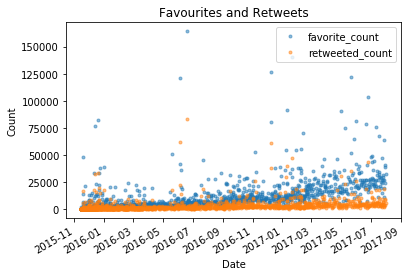

In [103]:
master_df[['favorite_count', 'retweeted_count']].plot(style = '.', alpha = 0.5)
plt.title('Favourites and Retweets')
plt.xlabel('Date')
plt.ylabel('Count');

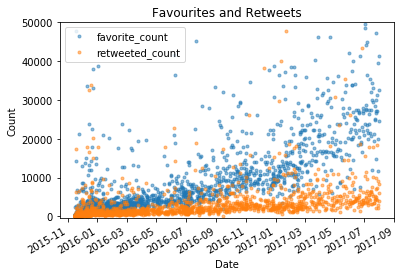

In [104]:
master_df[['favorite_count', 'retweeted_count']].plot(style = '.', alpha = 0.5)
plt.title('Favourites and Retweets')
plt.xlabel('Date')
plt.ylabel('Count');
x1,x2,y1,y2 = plt.axis()
#print (x1,x2,y1,y2)
plt.axis((x1,x2,-500,50000));

- Number of likes and number of retweets increased over time

Text(0.5, 1.0, 'Retweets vs favorites')

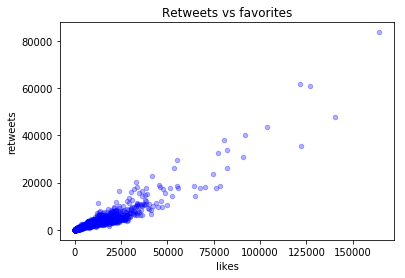

In [105]:
master_df.plot(kind = 'scatter', x = 'favorite_count', y = 'retweeted_count', alpha = 0.3, color = 'blue')
plt.xlabel('likes')
plt.ylabel('retweets')
plt.title('Retweets vs favorites')

- We can see linear dependency between 'likes' and how many times it was re

Let's check which stage of dogs gets highest rate, we will ignore denominator since it is always 10

In [106]:
master_df.groupby('dog_stage')['extracted_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,61.0,11.704918,1.636503,5.0,11.0,12.0,13.0,14.0
floofer,3.0,12.666667,0.577350,12.0,12.5,13.0,13.0,13.0
pupper,183.0,10.804699,1.408544,6.0,10.0,11.0,12.0,14.0
puppo,27.0,12.111111,1.219500,9.0,12.0,12.0,13.0,14.0


- The most popular breed in tweets is pupper. 

In [107]:
master_df['extracted_gender'].value_counts()

he     860
she    312
Name: extracted_gender, dtype: int64

In [108]:
860/312

2.7564102564102564

- It is way more male dogs posted then female

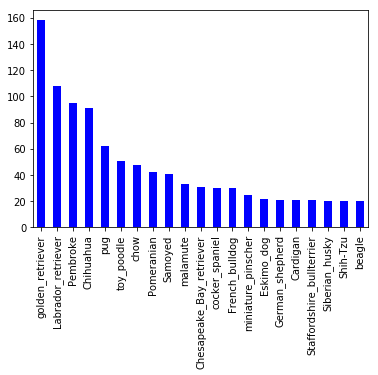

In [109]:
popular_breeds=master_df.groupby('p').filter(lambda x: len(x) >= 20)
popular_breeds['p'].value_counts().plot(kind = 'bar', color='blue')

- Golden retriever is the most popular breed

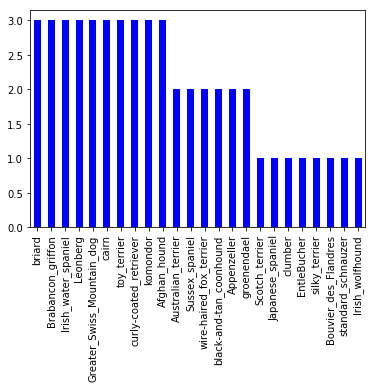

In [110]:
unpopular_breeds=master_df.groupby('p').filter(lambda x: len(x) <=3)
unpopular_breeds['p'].value_counts().plot(kind = 'bar', color='blue')